# Initial Conditions

To run a simulation we need something to run... 

Simulations need initial conditions (ICs) that define the positions and properties of particles of various species. In this workshop, we won't work through the entire process of making legitimate ICs with matter distributions consistent with our own Universe and cosmology. Later on, we will use some legitimate ICs, but to begin with, we will make some toy ICs to get an idea of the process.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import unyt

## Merging dark matter halos

To start with, let's ignore baryons (they're far too messy and get in the way). We can very easily create some initial conditions describing two merging dark matter halos, all we need to do is define the particle positions, velocities, and masses. In the cell below is a function that does just this. Take a look at what it does.

This function takes the mass of a particle in solar mass, the number of particles in each halo, the size of the box around the two halos (in comoving megaparsecs [cMpc]), the central positions of each halo in units of the box length, the size of each halo in units of the box length, and the magnitude of the velocity of each halo as arguments. You can set these freely but note that pathological setups may cause issues or indeed not run at all. Beyond the input arguments feel free to modify the code.

**BEWARE! Make the ICs too large and your computer will not be happy and the simulations will take too long to run if they don't crash your computer entirely!**

In [66]:
def make_merging_dm_halos(
    part_mass,
    npart1, 
    npart2, 
    boxsize, 
    halo1_pos, 
    halo2_pos, 
    halo1_size, 
    halo2_size, 
    halo1_vel, 
    halo2_vel
):
    """
    Make SWIFT initial conditions containing two dark matter halos.

    Args:
        part_mass (float)
            The mass of a particle in solar masses.
        npart1 (int)
            The number of particles in the dark matter halo.
        npart2 (int)
            The number of particles in the dark matter halo.
        boxsize (float)
            The size of the simulation box in Mpc.
        halo1_pos (array_like, float) [3]
            An array describing the position of a halo in units of the boxsize (i.e. 0 < halo1_pos < 1).
        halo2_pos (array_like, float) [3]
            An array describing the position of a halo in units of the boxsize (i.e. 0 < halo1_pos < 1).
        halo1_size (float)
            The size of the halo in units of the boxsize. This size is the standard deviation of the 
            Gaussian kernel used to define random particle positions.
        halo2_size (float)
            The size of the halo in units of the boxsize. This size is the standard deviation of the 
            Gaussian kernel used to define random particle positions.
        halo1_vel (float)
            The magnitude of a halo's velocity in km/s.
        halo2_vel (float)
            The magnitude of a halo's velocity in km/s.
    """

    # Convert quantities in boxsize units to cMpc
    halo1_pos *= boxsize
    halo2_pos *= boxsize
    halo1_size *= boxsize
    halo2_size *= boxsize

    # Define the particle positions for each halo.
    part1_pos = np.zeros((npart1, 3))
    part2_pos = np.zeros((npart2, 3))
    part1_pos[:, 0] = np.random.normal(loc=halo1_pos[0], scale=halo1_size, size=npart1)
    part1_pos[:, 1] = np.random.normal(loc=halo1_pos[1], scale=halo1_size, size=npart1)
    part1_pos[:, 2] = np.random.normal(loc=halo1_pos[2], scale=halo1_size, size=npart1)
    part2_pos[:, 0] = np.random.normal(loc=halo2_pos[0], scale=halo2_size, size=npart2)
    part2_pos[:, 1] = np.random.normal(loc=halo2_pos[1], scale=halo2_size, size=npart2)
    part2_pos[:, 2] = np.random.normal(loc=halo2_pos[2], scale=halo2_size, size=npart2)

    # Define some velocities, although not realistic we can start with all particles
    # having the same velocity as the bulk velocity of the halo + some random contribution.

    # To calculate velocities we need unit vectors to point the halos at each other
    direction_vectors = halo2_pos - halo1_pos
    normalized_direction_vectors = direction_vectors / np.linalg.norm(direction_vectors)

    # Calculate velocities...
    part1_vel = np.full_like(part1_pos, normalized_direction_vectors * halo1_vel)
    part2_vel = np.full_like(part2_pos, -normalized_direction_vectors * halo2_vel)

    # ... and add some random scatter
    part1_vel += np.random.normal(loc=0, scale=0.1 * halo1_vel, size=(npart1, 3))
    part2_vel += np.random.normal(loc=0, scale=0.1 * halo2_vel, size=(npart2, 3))

    # Combine the halo arrays into single arrays
    pos = np.concatenate((part1_pos, part2_pos))
    vel = np.concatenate((part1_vel, part2_vel))

    # Create the particle mass array
    masses = np.full(npart1 + npart2, part_mass)

    print("Made halos with masses: log_10(M_1 / Msun) = "
          "%.2f & log_10(M_2 / Msun) = %.2f" % (np.log10(part_mass * npart1), np.log10(part_mass * npart2)))
    
    return pos, vel, masses

# Define the boxsize
boxsize = 10

# Make the halos
pos, vel, masses = make_merging_dm_halos(
    part_mass=10**6,
    npart1=100000, 
    npart2=50000, 
    boxsize=boxsize, 
    halo1_pos=np.array([0.2, 0.3, 0.2]), 
    halo2_pos=np.array([0.6, 0.65, 0.8]), 
    halo1_size=0.05, 
    halo2_size=0.05, 
    halo1_vel=100, 
    halo2_vel=100
)

Made halos with masses: log_10(M_1 / Msun) = 11.00 & log_10(M_2 / Msun) = 10.70


Let's take a look at what we've made.

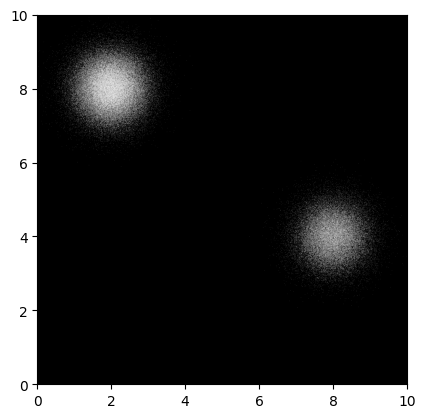

In [67]:
# Make a quick and dirty 2D histogram to visualise
H, _, _ = np.histogram2d(pos[:, 0], pos[:, 2], bins=np.arange(0, boxsize + 0.01, 0.01))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(np.arcsinh(H), cmap="Greys_r", extent=[0, boxsize, 0, boxsize])
plt.show()
plt.close()

Of course, what we've done here is simple make some arrays. Now we need to convert them into IC files that SWIFT will understand. 

## Initial condition format

SWIFT's (and many other simulations') ICs are in HDF5 format. This format is ubiquitous in theoretical astrophysics and computing in general due to its simplicity, Python interface (`h5py`), and ability to load subsets of data. 

The interface to HDF5 files in Python functions similar to dictionaries with data stored under keys and accessed using `hdf["key"]` syntax (with some caveats). We will show this below in a bit more detail, if you haven't come across HDF5 format files before it's worth getting familiar with them separately. It's an incredibly powerful data format.

We can convert what we've made above into ICs by making use of `swiftsimio`'s `Writer` utility. Below I've defined a function that takes what was created above and saves it as a HDF5 file.

In [73]:
from swiftsimio.units import cosmo_units
from swiftsimio import Writer


def make_dmo_ics(boxsize, pos, vel, masses):
    """
    Convert arrays describing the particle distribution to an IC file.
    """
    
    # Associate units to the arrays and boxsize
    boxsize *= unyt.Mpc
    pos *= unyt.Mpc
    vel *= unyt.km / unyt.s
    masses *= unyt.Msun

    # Generate object. cosmo_units corresponds to default Gadget-oid units
    # of 10^10 Msun, Mpc, and km/s
    ics = Writer(cosmo_units, boxsize, dimension=3)

    # Attach the particle arrays
    ics.dark_matter.coordinates = pos
    ics.dark_matter.velocities = vel
    ics.dark_matter.masses = masses

    # Finally, write the ICs
    ics.write("../ics/dmo_merger.hdf5")


make_dmo_ics(boxsize, pos, vel, masses)

There are a couple of things to note in the above. Firstly, `swiftsimio` makes use of unyt so we have associated all properties with their units to ensure consistency. Next, you'll see the `Writer` class is initialised with a `cosmo_units` object. This object encodes everything about the cosmological unit system and ensures that the initial conditions are correctly interpreted when SWIFT reads the ICs. Finally, you may have noticed we have only interacted with the `dark_matter` portion of the ICs. Next, we'll move on to those pesky baryons but first, take a look at [DMO Simulations](DMO_Simulations.ipynb) and then come back after completing the tutorial there.

## Adding Baryons to the halos

